# Project 4 : Microsoft Stock Market analysis and prediction

### <font color='blue'> Team members: </font>
 1. Abeer Alzuhair
 2. Rawan Mohammed Eid
 3. Razan Alsulieman
 

## Problem statement

Microsoft is an American multinational technology company. It develops, manufactures, licenses, supports, and sells computer software, consumer electronics, personal computers, and related services. Its best known software products are the Microsoft Windows line of operating systems, the Microsoft Office suite, and the Internet Explorer and Edge web browsers.


In this project, we will use historical data of the Microsoft Stock market (from 2015) to forecast the stock closing prices for one upcoming year. This is a TimeSeries prediction problem, which we will try to solve using (SARIMAX, Facebook Prophet, RNN LSTM cells (Long Short-Term Memory)) models.
And to evaluate the accuracy of our models we will use the root-mean-square error (RMSE), this metric is commonly used in forecasting, to find the standard deviation of the prediction errors.

### Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
np.set_printoptions(precision=4)
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tools.eval_measures import rmse

### Load the data

In [2]:
microsoft = pd.read_csv('./MSFT_Stock.csv')

### Data Description

 - [Data Source](https://www.kaggle.com/rawaneid/microsoft-stock-market-2001-2021)
 - Data Information: Time Series for Microsoft Company Stock Market in a decade (2001 - 2021)


|column|Description|
|--|--|
|**datetime**| datetime in UTC referring to when the bar with specified interval was opened|
|**open**|	The price of MSFT when the stock market opens|
|**high**|	The highest price of MSFT during that trading day|
|**low**|	The lowest price of MSFT during that trading day|
|**close**|	The price of MSFT when the stock market closes|
|**Volume**| How many shares of MSFT were traded that day|

### Inspect the data:

In [3]:
#see the head
microsoft.head()

,Unnamed: 0,open,high,low,close,volume
0,2001-03-16,26.25000,27.56250,26.24219,27.28125,112848800
1,2001-03-19,27.25000,27.75000,26.56250,27.15625,61036400
2,2001-03-20,27.28125,28.06250,26.31250,26.34375,91822800
3,2001-03-21,26.12500,26.62500,24.87500,25.03125,124988600
4,2001-03-22,25.28125,27.03125,25.25000,27.00000,126363200


In [4]:
#see the tail
microsoft.tail()

,Unnamed: 0,open,high,low,close,volume
4995,2021-01-25,229.12000,229.78000,224.22,229.53000,33152095
4996,2021-01-26,231.86000,234.17999,230.08,232.33000,48699200
4997,2021-01-27,238.00000,240.44000,230.14,232.89999,69757500
4998,2021-01-28,235.61000,242.64000,235.09,238.92999,48990000
4999,2021-01-29,235.99001,238.01500,231.36,231.96001,40004239


In [5]:
#check if there is null values
microsoft.isnull().sum()

Unnamed: 0    0
open          0
high          0
low           0
close         0
volume        0
dtype: int64

In [6]:
# see the data type
microsoft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5000 non-null   object 
 1   open        5000 non-null   float64
 2   high        5000 non-null   float64
 3   low         5000 non-null   float64
 4   close       5000 non-null   float64
 5   volume      5000 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 234.5+ KB


## Data Cleaning and EDA

In [7]:
# The data is almost clean, it is already sorted and there are no null values

In [8]:
# drop the unused columns
microsoft.drop(['open', 'high', 'low', 'volume'], axis=1, inplace=True)

In [9]:
# Rename date column
microsoft.rename(columns={'Unnamed: 0':'date'}, inplace=True)

In [10]:
# change "date" column to datetime type
microsoft['date'] = pd.to_datetime(microsoft.date)

In [11]:
# drop all data before 1-1-2015
microsoft = microsoft[microsoft['date'] >= '2015-01-01']

In [12]:
# see the shape of file
microsoft.shape

(1530, 2)

In [13]:
# make datetime index 
microsoft.set_index('date',inplace=True,drop=True)

In [14]:
# set freq to B (business day frequency)
microsoft = microsoft.asfreq('B') # this method will add new rows with null values for the missing dates

In [15]:
#check if there is null values
microsoft[microsoft.close.isnull()==True].index

DatetimeIndex(['2015-01-19', '2015-02-16', '2015-04-03', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-11-26', '2015-12-25',
               '2016-01-01', '2016-01-18', '2016-02-15', '2016-03-25',
               '2016-05-30', '2016-07-04', '2016-09-05', '2016-11-24',
               '2016-12-26', '2017-01-02', '2017-01-16', '2017-02-20',
               '2017-04-14', '2017-05-29', '2017-07-04', '2017-09-04',
               '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-03-30', '2018-05-28', '2018-07-04',
               '2018-09-03', '2018-11-22', '2018-12-05', '2018-12-25',
               '2019-01-01', '2019-01-21', '2019-02-18', '2019-04-19',
               '2019-05-27', '2019-07-04', '2019-09-02', '2019-11-28',
               '2019-12-25', '2020-01-01', '2020-01-20', '2020-02-17',
               '2020-04-10', '2020-05-25', '2020-07-03', '2020-09-07',
               '2020-11-26', '2020-12-25', '2021-01-01', '2021-01-18'],
     

In [16]:
#check the number of null values
microsoft.isnull().sum()

close    56
dtype: int64

In [17]:
# check the shape dataframe after adding the missing dates 
microsoft.shape

(1586, 1)

In [18]:
# replace nulls by the preceding values (the value of the day before)
microsoft.fillna(method='ffill', inplace=True)

In [19]:
#check if there is null values
microsoft.isnull().sum()

close    0
dtype: int64

In [20]:
microsoft.head()

,close
date,
2015-01-02,46.76
2015-01-05,46.33
2015-01-06,45.65
2015-01-07,46.23
2015-01-08,47.59


In [21]:
microsoft.tail()

,close
date,
2021-01-25,229.53000
2021-01-26,232.33000
2021-01-27,232.89999
2021-01-28,238.92999
2021-01-29,231.96001


## Visualization

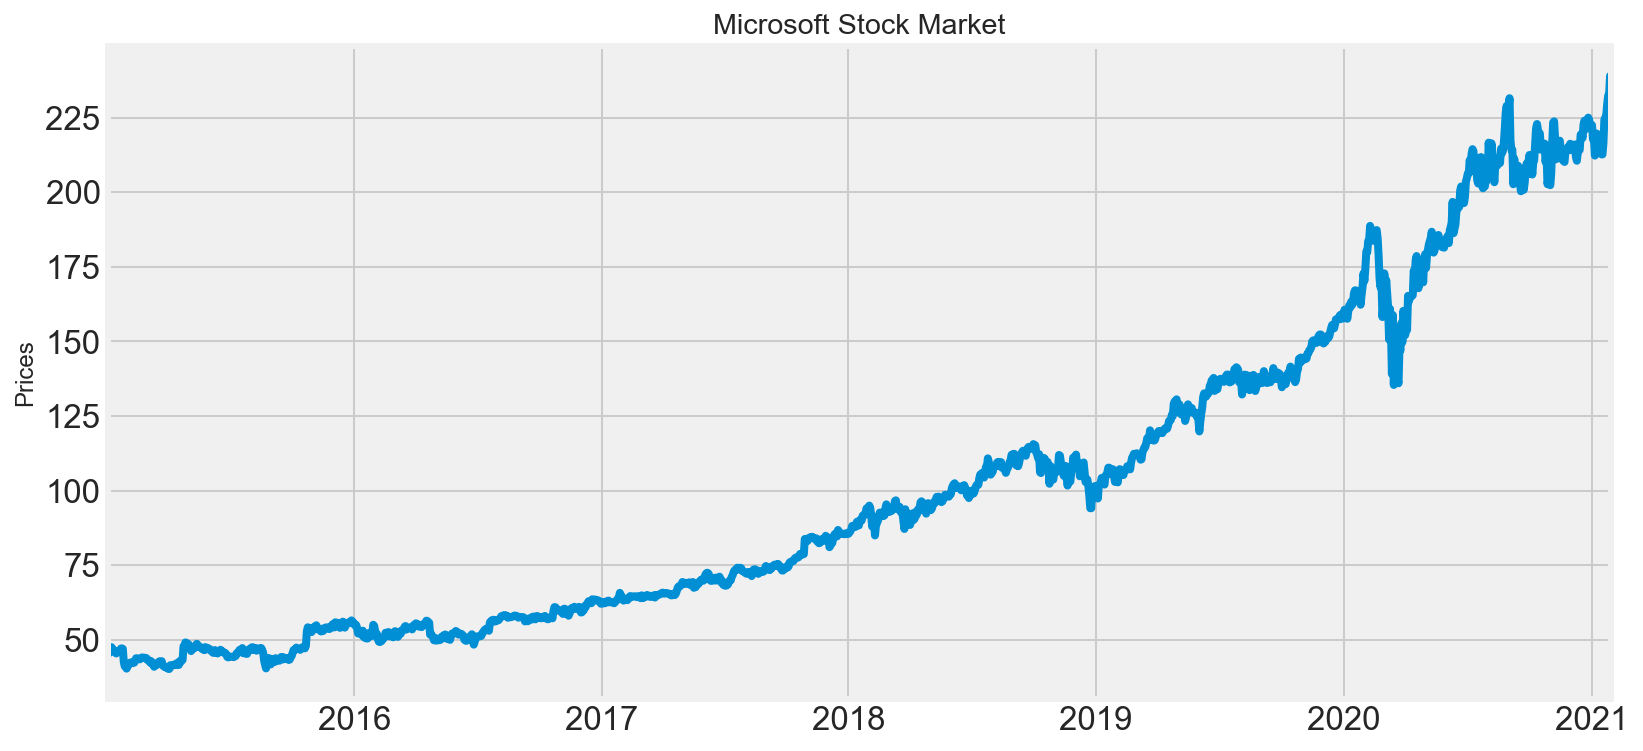

In [22]:
# Plot the close prices
title = 'Microsoft Stock Market'
ylabel='Prices'
xlabel='' 

ax = microsoft['close'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

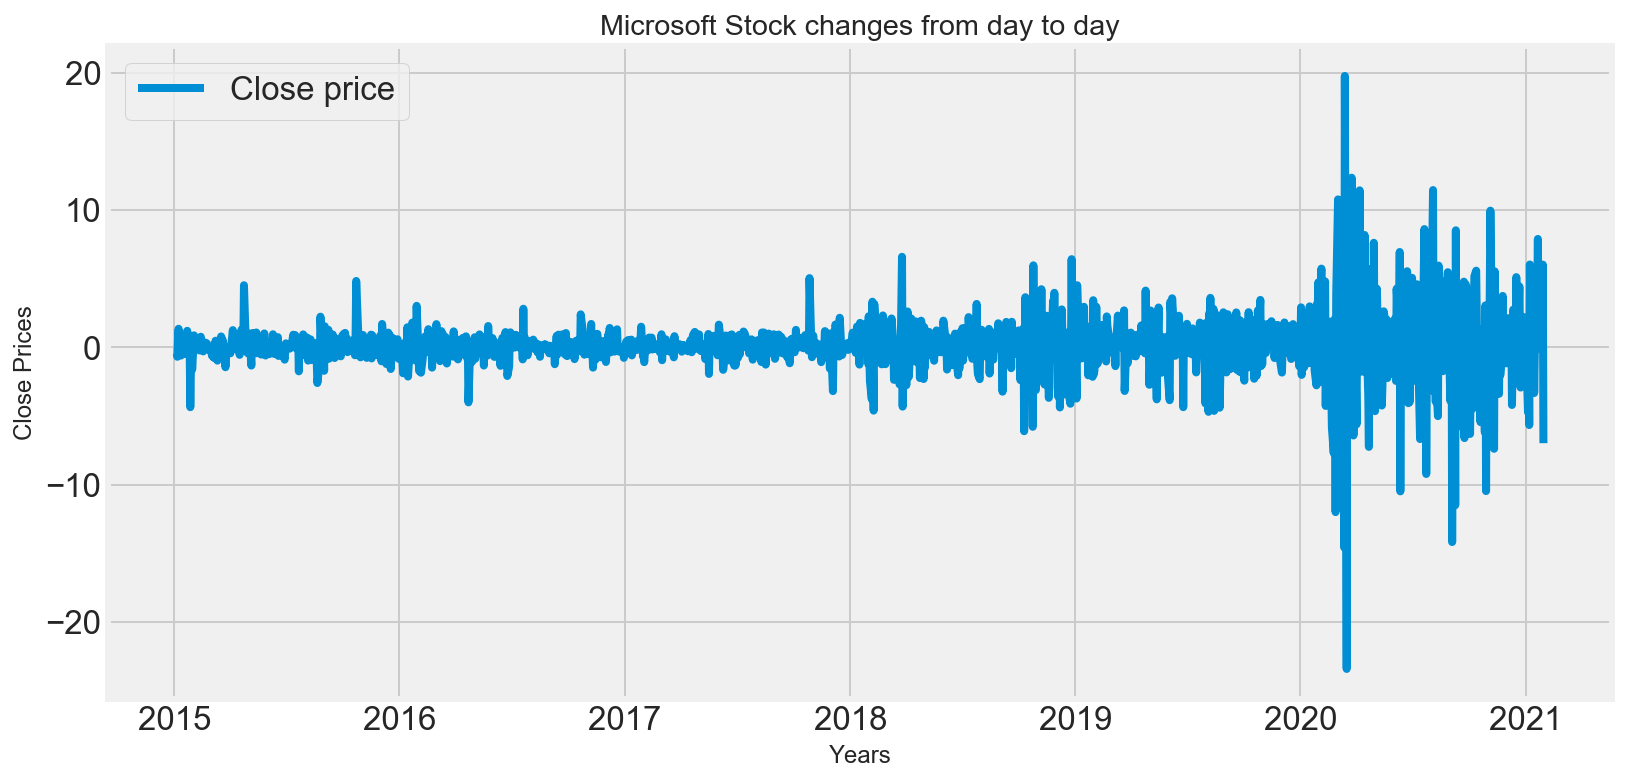

In [23]:
# plot the difference between day to day
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Years')
plt.ylabel('Close Prices')
plt.plot(microsoft.diff()[['close']])
plt.title('Microsoft Stock changes from day to day')
plt.legend( ["Close price"])
plt.show()

#####  - We can observe from above that the stock price is increasing over time, and we assume that was because of the increasing demand for Microsoft products. </font> 
##### - We can also see that the changes in the stock prices were not normal in the year 2020, and that was probably because of the Covid 19 pandemic. </font> 

## Check for Seasonality

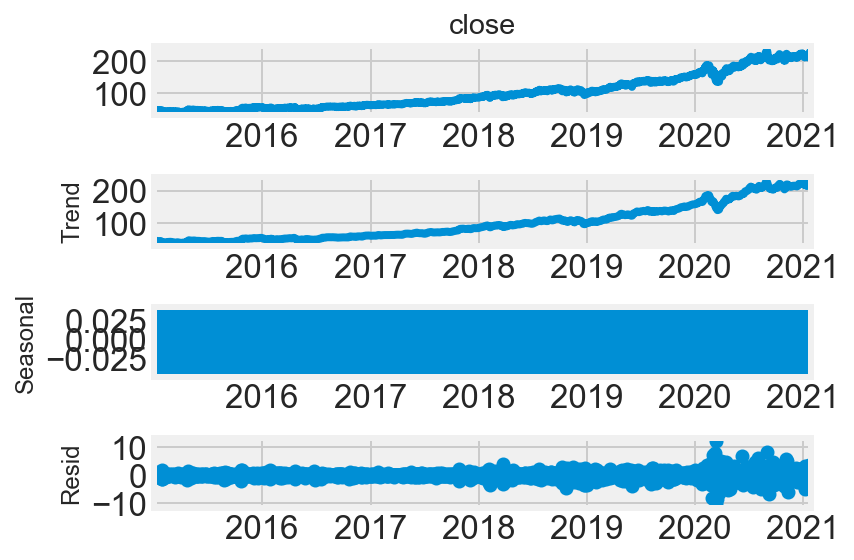

In [24]:
result = seasonal_decompose(microsoft['close']) 
result.plot();

##### We cant tell from the above figure if the data are Seasonal or Not, so, we need to plot the seasonality on a higher scale

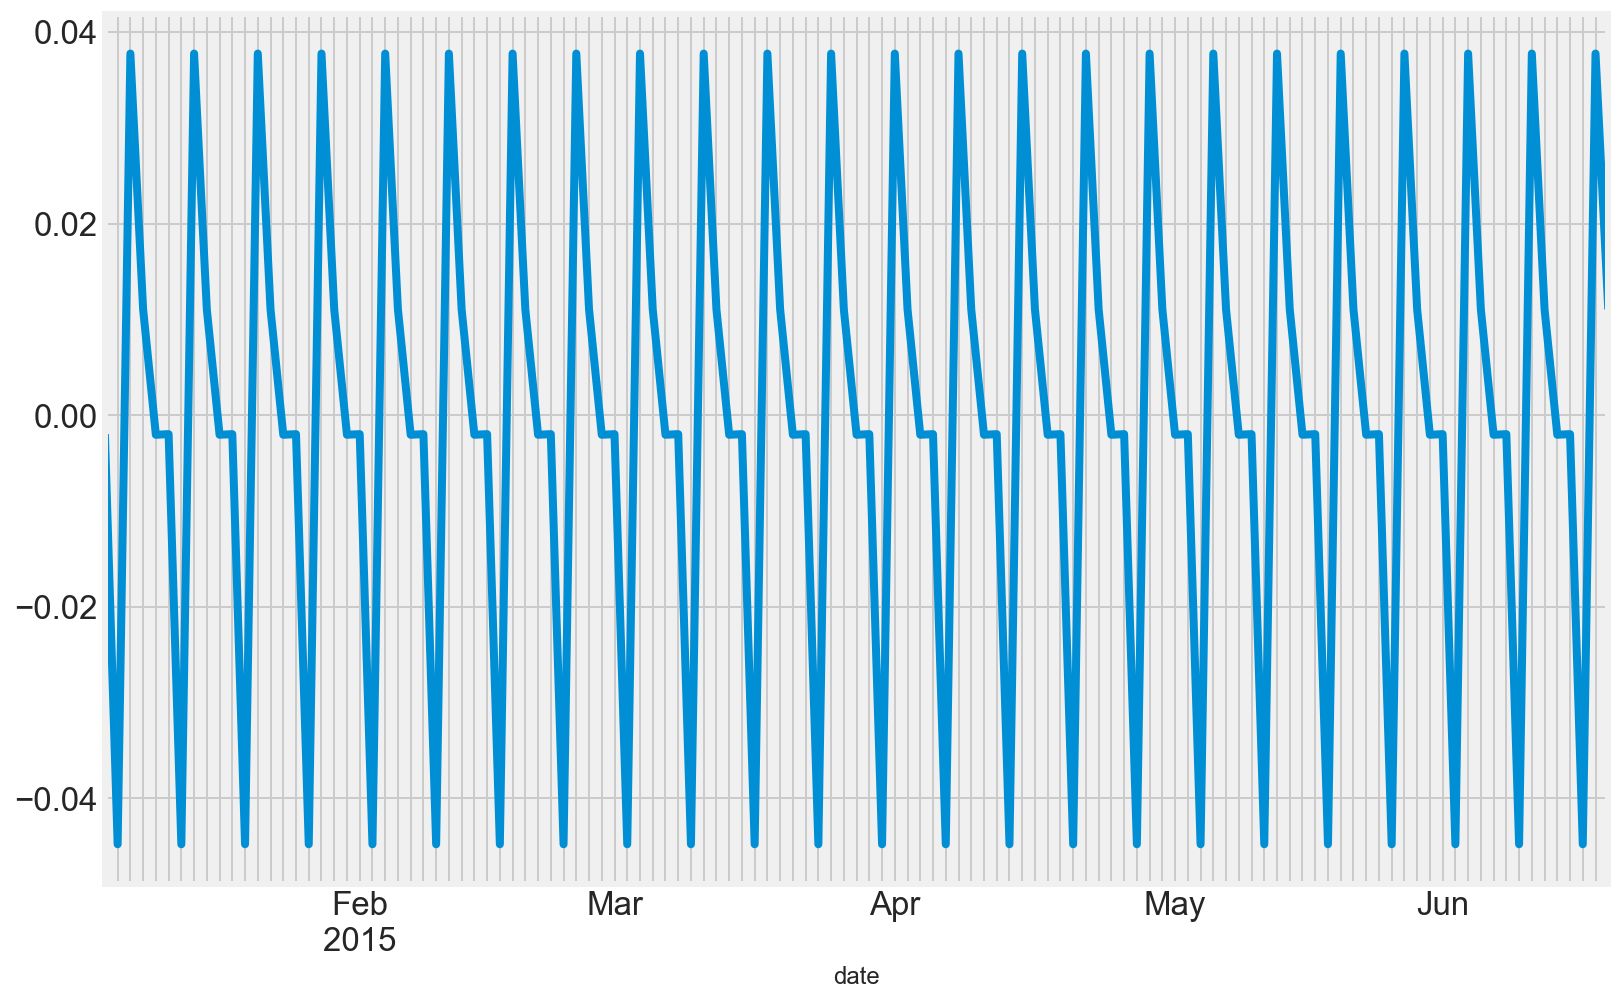

In [25]:
# plot the seasonlity in a higher scale
ax=result.seasonal[1:120].plot(figsize=(12,8))

max_xticks = 120 
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

##### - We can observe from above that our data is clearly seasonal, where the seasonality is every week (five business days, m=5) </font> 

---

## Split the data into train/test sets

In [26]:
# Set one year for testing (260 business days)
df_train = microsoft.iloc[:-260]
df_test = microsoft.iloc[-260:]

In [27]:
len(df_train),len(df_test)

(1326, 260)

----

# Modeling

## <font color='blue'> Model_1: SARAMIX  (Abeer) </font> 

### Run <tt>auto_arima</tt> to obtain recommended orders

In [69]:
from pmdarima.arima import auto_arima

In [70]:
# For SARIMA Orders we set seasonal=True and pass in an m=5 (5 business days in this datasets)
auto_arima(microsoft['close'], seasonal=True , m=5)

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 5),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

### Fit a SARIMAX Model

In [71]:
model1 = SARIMAX(df_train['close'], order=(3, 1, 2), seasonal_order=(1, 0, 1, 5))
results1 = model1.fit()

/Users/rzanabdullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rzanabdullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Predict

In [72]:
# Obtain predicted values on test data
start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions1 = results1.predict(start=start, end=end, typ='levels').rename('SARIMAX(3, 1, 2)(1, 0, 1, 5) Predictions')

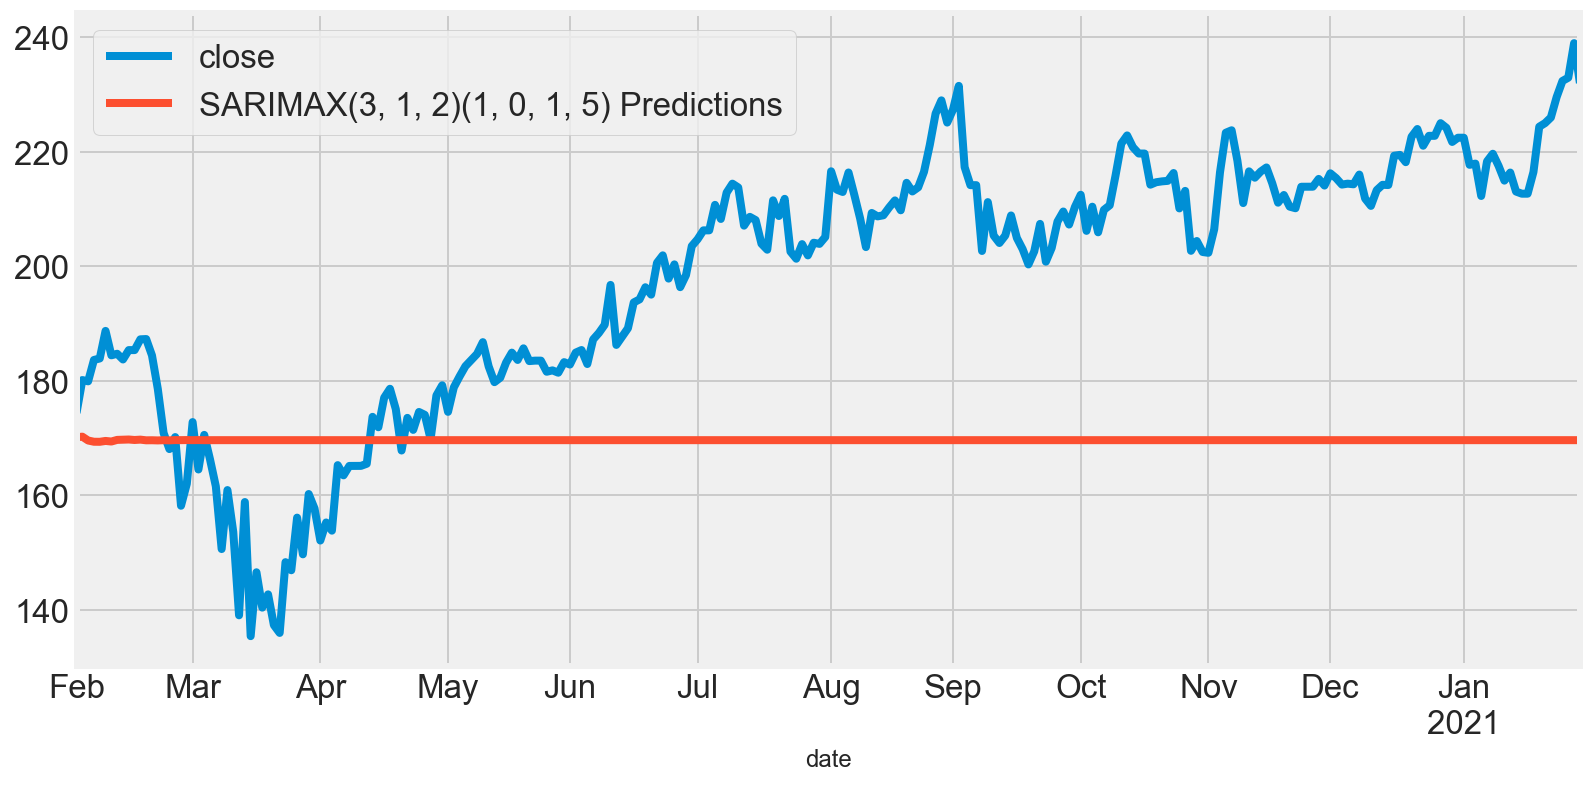

In [73]:
# Plot predictions against known values
ax = df_test['close'].plot(legend=True,figsize=(12,6));
predictions1.plot(legend=True);
ax.autoscale(axis='x',tight=True)

### Evaluate the Model

In [33]:
error1 = rmse(df_test['close'], predictions1)
print(f'SARIMAX(3, 1, 2)(1, 0, 1, 5) RMSE Error: {error1:4.8}')

SARIMAX(3, 1, 2)(1, 0, 1, 5) RMSE Error: 36.005781


In [34]:
df_test['close'].mean()

197.82330273076923

### Retrain the model on the full data, and forecast the NEXT YEAR PRICES

In [35]:
model = SARIMAX(microsoft['close'], order=(3, 1, 2), seasonal_order=(1, 0, 1, 5))
results = model.fit()
fcast = results.predict(len(microsoft), len(microsoft)+260 , typ='levels').rename('SARIMAX(3, 1, 2)(1, 0, 1, 5) Forecast')

C:\Users\123\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


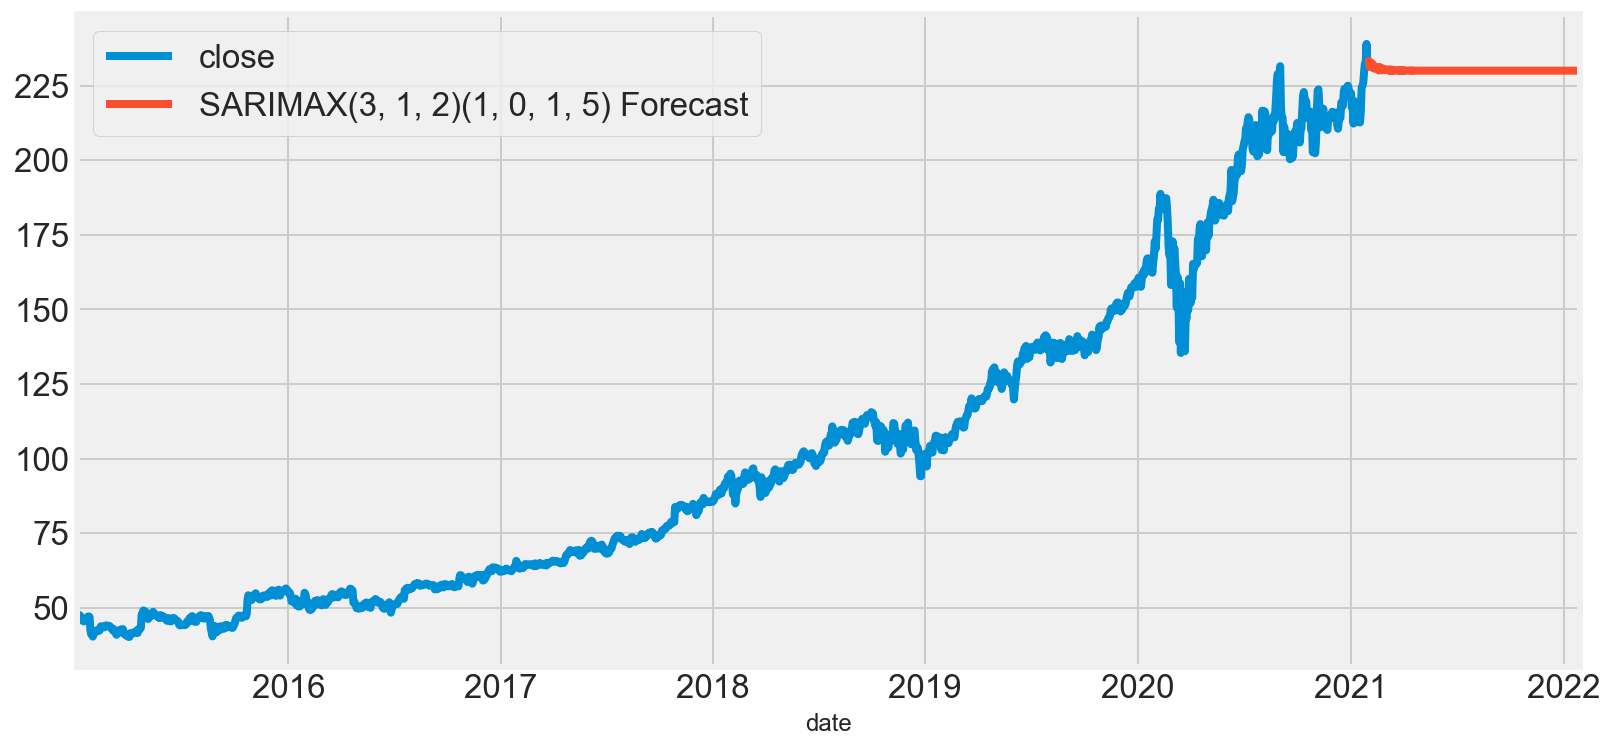

In [36]:
# Plot predictions against known values
ax = microsoft['close'].plot(legend=True,figsize=(12,6));
fcast.plot(legend=True);
ax.autoscale(axis='x',tight=True)

----

## <font color='blue'> Model_2: Facebook Prophet  (Rawan) </font> 

In [37]:
# make a copy to maniplute it freely
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [38]:
df_test_copy.head()

,close
date,
2020-02-03,174.38000
2020-02-04,180.12000
2020-02-05,179.89999
2020-02-06,183.63000
2020-02-07,183.89000


In [39]:
# reset index 
df_train_copy.reset_index(inplace =True)
df_test_copy.reset_index(inplace =True)

**Print the head to see the changes**

In [40]:
#train dataframe
df_train_copy.head()

,date,close
0,2015-01-02,46.76
1,2015-01-05,46.33
2,2015-01-06,45.65
3,2015-01-07,46.23
4,2015-01-08,47.59


In [41]:
#rename the columns
df_train_copy.rename(columns = {'date':'ds','close':'y'}, inplace = True)

In [42]:
# print one of the dataframes to double check our changes
df_train_copy.head()

,ds,y
0,2015-01-02,46.76
1,2015-01-05,46.33
2,2015-01-06,45.65
3,2015-01-07,46.23
4,2015-01-08,47.59


### train the data

In [43]:
# import facebook prophet 
from fbprophet import Prophet

In [44]:
# initiate the model
m = Prophet()#daily_seasonality=True)
model = m.fit(df_train_copy)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
future = m.make_future_dataframe(periods = 260  , freq = 'B')
forecast_test = m.predict(future)

In [46]:
forecast_test.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1576,2021-01-18,220.314347,169.933802,265.475119,168.636359,264.610224,0.479968,0.479968,0.479968,-0.126020,-0.126020,-0.126020,0.605988,0.605988,0.605988,0.0,0.0,0.0,220.794315
1577,2021-01-19,220.473165,169.929586,265.957541,168.666366,265.055229,0.497878,0.497878,0.497878,-0.176107,-0.176107,-0.176107,0.673986,0.673986,0.673986,0.0,0.0,0.0,220.971044
1578,2021-01-20,220.631984,170.035504,266.477050,168.696373,265.520723,0.591437,0.591437,0.591437,-0.126577,-0.126577,-0.126577,0.718013,0.718013,0.718013,0.0,0.0,0.0,221.223420
1579,2021-01-21,220.790802,169.754765,266.591132,168.726380,265.981854,0.739302,0.739302,0.739302,0.001352,0.001352,0.001352,0.737950,0.737950,0.737950,0.0,0.0,0.0,221.530104
1580,2021-01-22,220.949620,169.379382,267.812134,168.756387,266.423012,0.793800,0.793800,0.793800,0.059588,0.059588,0.059588,0.734213,0.734213,0.734213,0.0,0.0,0.0,221.743421
1581,2021-01-25,221.426075,168.824561,268.483277,168.153984,267.784387,0.466763,0.466763,0.466763,-0.126020,-0.126020,-0.126020,0.592783,0.592783,0.592783,0.0,0.0,0.0,221.892838
1582,2021-01-26,221.584894,168.765779,268.501982,167.924886,268.248041,0.332397,0.332397,0.332397,-0.176107,-0.176107,-0.176107,0.508505,0.508505,0.508505,0.0,0.0,0.0,221.917291
1583,2021-01-27,221.743712,169.522731,268.072754,167.695788,268.711695,0.283213,0.283213,0.283213,-0.126577,-0.126577,-0.126577,0.409790,0.409790,0.409790,0.0,0.0,0.0,222.026925
1584,2021-01-28,221.902530,168.623230,270.535232,167.466691,269.175349,0.300939,0.300939,0.300939,0.001352,0.001352,0.001352,0.299587,0.299587,0.299587,0.0,0.0,0.0,222.203469
1585,2021-01-29,222.061349,168.864120,269.044464,167.237593,269.639003,0.240647,0.240647,0.240647,0.059588,0.059588,0.059588,0.181060,0.181060,0.181060,0.0,0.0,0.0,222.301996


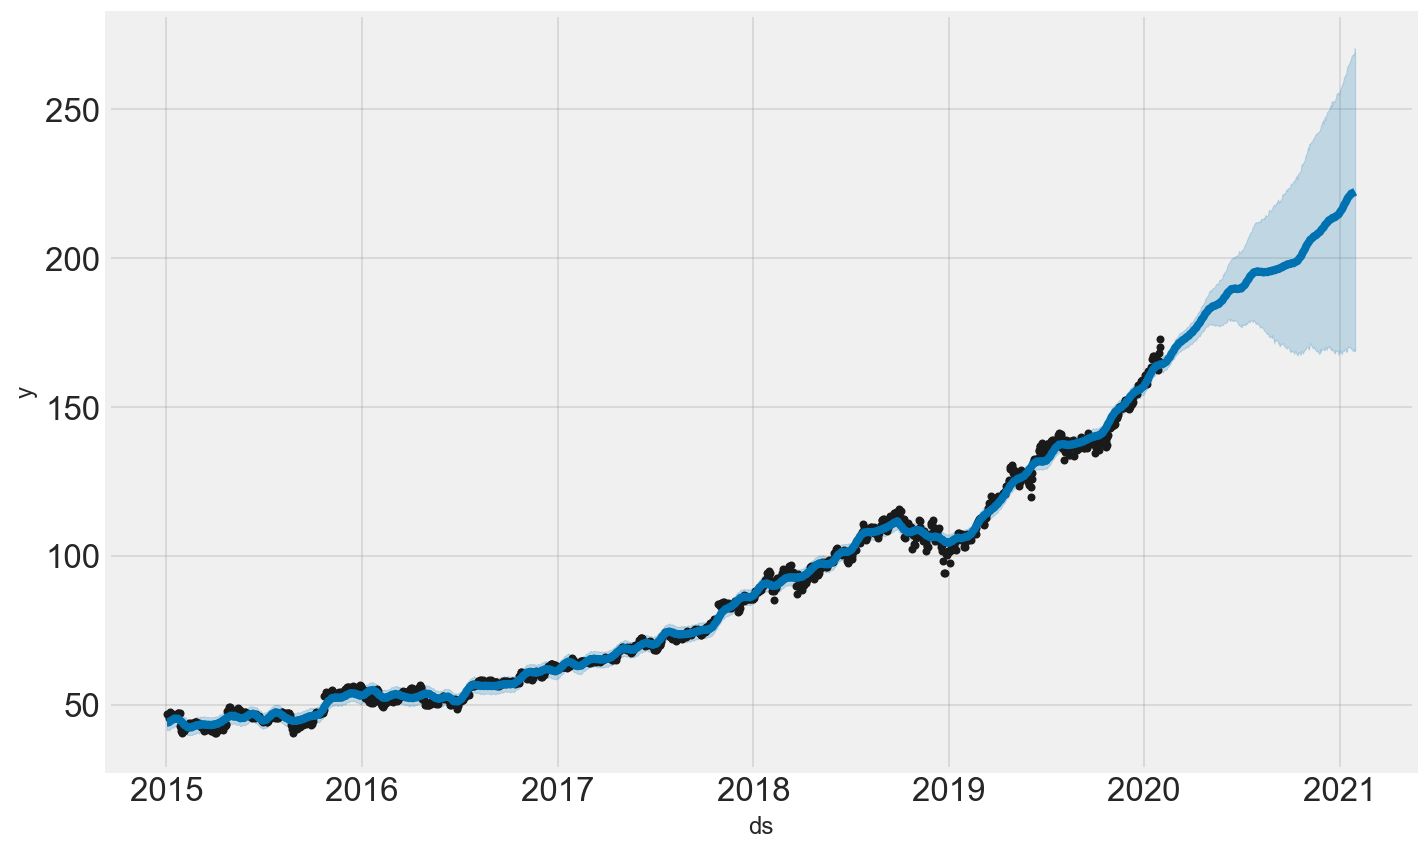

In [47]:
#Prophet also provides a convenient method to quickly plot the results of our forecasts.
m.plot(forecast_test)
plt.show()

- black dot : The true data points in our data set 
- Dark blue line : the predicted values
- light blue shade : the boundries

In [48]:
# make df for all the predicted values
predicted = forecast_test[['ds','yhat']]
predicted = predicted.iloc[-260:]
predicted.head()

,ds,yhat
1326,2020-02-03,164.263602
1327,2020-02-04,164.264216
1328,2020-02-05,164.375964
1329,2020-02-06,164.580080
1330,2020-02-07,164.730565


### Evaluate <tt>fbprophet</tt> model

In [28]:
from statsmodels.tools.eval_measures import rmse

In [50]:
error1 = rmse(df_test_copy['close'], predicted['yhat'])
print(f'Facebook Propet RMSE Error: {error1:4.8}')

Facebook Propet RMSE Error: 13.463951


In [51]:
df_test_copy['close'].mean()

197.82330273076923

In [52]:
# return index
predicted.set_index('ds',inplace=True,drop=True)
df_test_copy.set_index('date',inplace=True,drop=True)

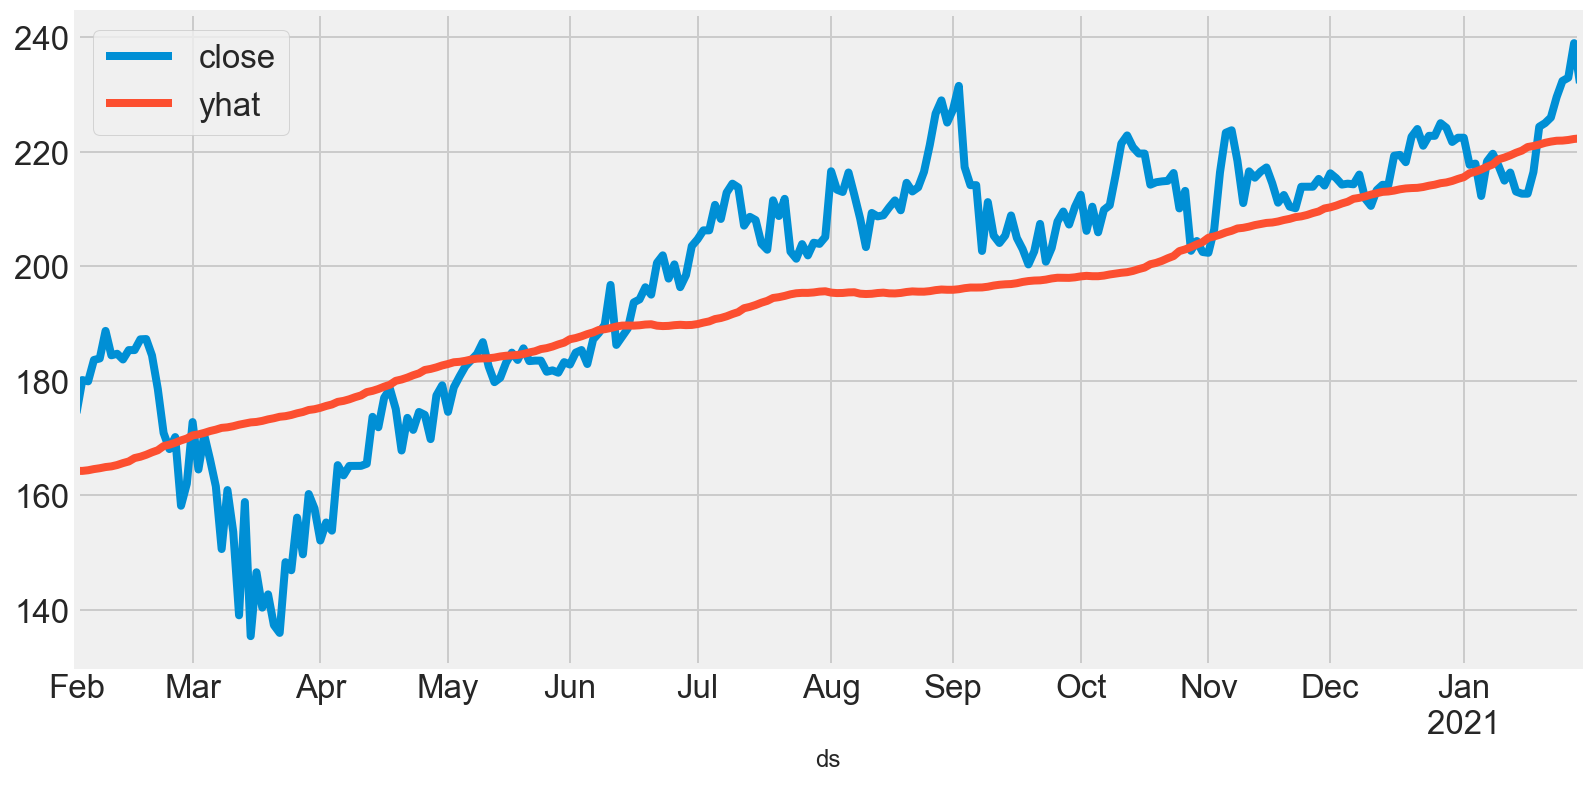

In [53]:
ax = df_test_copy['close'].plot(legend=True,figsize=(12,6));
predicted.plot(legend=True,ax = ax);
ax.autoscale(axis='x',tight=True)

### Forcasting with original data
**After training and testing our model, now we will retrain our model with the complete data to forecast the future .**

In [54]:
microsoft_copy = microsoft.copy() # copy of original
microsoft_copy.reset_index(inplace =True) # reset index 
microsoft_copy.rename(columns = {'date':'ds','close':'y'}, inplace = True) # rename columns

In [55]:
prophet_model = Prophet()
retrain = prophet_model.fit(microsoft_copy)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
future_dates = prophet_model.make_future_dataframe(periods = 260  , freq = 'B')
forecast_close = prophet_model.predict(future_dates)

In [57]:
forecast_close.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1841,2022-01-24,297.219940,279.647029,312.594076,283.111046,312.563030,-0.908079,-0.908079,-0.908079,-0.171727,-0.171727,-0.171727,-0.736353,-0.736353,-0.736353,0.0,0.0,0.0,296.311861
1842,2022-01-25,297.403764,281.057376,312.608065,283.232802,312.852243,-0.755196,-0.755196,-0.755196,-0.177632,-0.177632,-0.177632,-0.577564,-0.577564,-0.577564,0.0,0.0,0.0,296.648568
1843,2022-01-26,297.587587,281.616919,313.454738,283.351762,313.141456,-0.486897,-0.486897,-0.486897,-0.062931,-0.062931,-0.062931,-0.423966,-0.423966,-0.423966,0.0,0.0,0.0,297.100690
1844,2022-01-27,297.771411,281.624634,314.327593,283.492334,313.430669,-0.316834,-0.316834,-0.316834,-0.040185,-0.040185,-0.040185,-0.276650,-0.276650,-0.276650,0.0,0.0,0.0,297.454577
1845,2022-01-28,297.955235,282.247364,314.349582,283.630172,313.719882,-0.169293,-0.169293,-0.169293,-0.032778,-0.032778,-0.032778,-0.136515,-0.136515,-0.136515,0.0,0.0,0.0,297.785942


In [58]:
forecast_close.shape

(1846, 19)

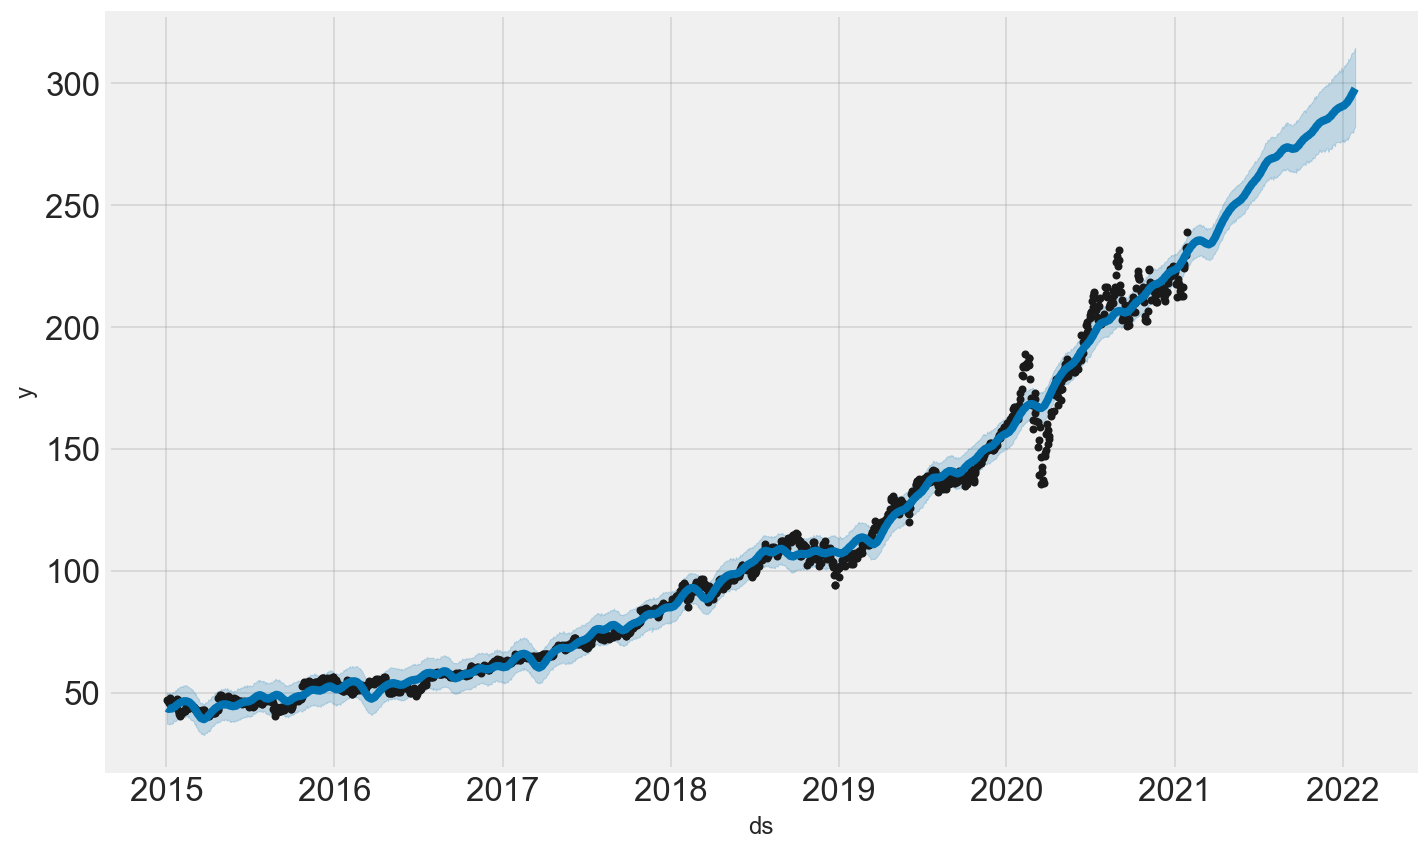

In [59]:
#Prophet also provides a convenient method to quickly plot the results of our forecasts.
prophet_model.plot(forecast_close)
plt.show()

----

## <font color='blue'> Model_3: RNN LSTM cells (Long Short-Term Memory) (Razan) </font> 

- LSTM: Long-Short-Term_memory networks are a form of Recurrent Neural Networks. 
    Some advantages of neural networks are:
        - They can model any non-linear function.
        - They give good results without much parameter tuning.

In [66]:
# make a copy to maniplute it freely
df_training = df_train.copy()
df_testing = df_test.copy()

In [67]:
df_tr=df_training[:'2019']['close'].values
df_ts=df_testing['2019':]['close'].values

In [68]:
## reshape your data
df_tr = df_tr.reshape(len(df_tr),1)
df_ts = df_ts.reshape(len(df_ts),1)
df_tr.shape , df_ts.shape

((1303, 1), (260, 1))

In [69]:
## scalling your data to increase your efficiency
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(df_tr)
#test_scaled = sc.transform(df_ts)

In [70]:
X_train = []
y_train = []
for i in range(60, 1303):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [72]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#defining the Dropout layers, specifing 0.2, which means that 20% of the layers will be dropped
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

#compile the model using the 'adam' optimizer and set the loss as the 'mean_squarred_error'
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#fit the model to run on 100 epochs with a batch size of 32
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1243/1243 [==============================] - 11s 9ms/step - loss: 0.0311
Epoch 2/100
1243/1243 [==============================] - 6s 5ms/step - loss: 0.0038
Epoch 3/100
1243/1243 [==============================] - 5s 4ms/step - loss: 0.0029
Epoch 4/100
1243/1243 [==============================] - 5s 4ms/step - loss: 0.0028
Epoch 5/100
1243/1243 [==============================] - 5s 4ms/step - loss: 0.0029
Epoch 6/100
1243/1243 [==============================] - 4s 3ms/step - loss: 0.0027
Epoch 7/100
1243/1243 [==============================] - 5s 4ms/step - loss: 0.0024
Epoch 8/100
1243/1243 [==============================] - 5s 4ms/step - loss: 0.0020
Epoch 9/100
1243/1243 [==============================] - 4s 3ms/step - loss: 0.0024
Epoch 10/100
1243/1243 [==============================] - 4s 3ms/step - loss: 0.0019
Epoch 11/100
1243/1243 [==============================] - 4s 3ms/step - loss: 0.0022
Epoch 12/100
1243/1243 [==============================] - 6s 5ms/step - l

## Forcasting with original data

In [73]:
dataset_total = pd.concat((df_training,df_testing), axis = 0)
inputs = dataset_total[len(dataset_total) - len(df_testing) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 321):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock = model.predict(X_test)
#getting the values in normal readable format
predicted_stock = sc.inverse_transform(predicted_stock)

In [74]:
from sklearn.metrics import mean_squared_error
import math
error1 = rmse(df_test['close'], predicted_stock)
print('RNN LSTM RMSE Error:{}'.format(error1.mean()))

RNN LSTM RMSE Error:27.03758934948397


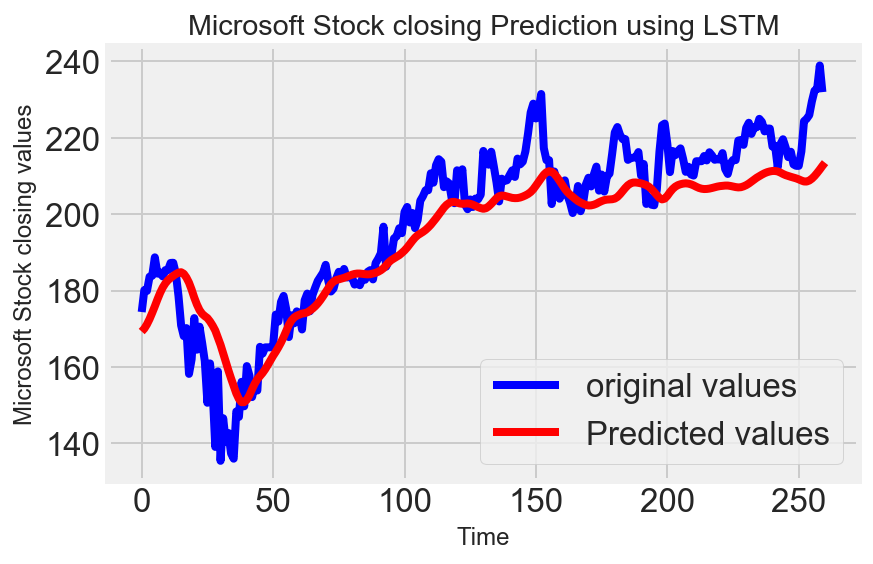

In [75]:
plt.plot(df_ts, color = 'blue', label = 'original values')
plt.plot(predicted_stock, color = 'red', label = 'Predicted values')
plt.title('Microsoft Stock closing Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock closing values')
plt.legend()
plt.show()

-  From the plot above we can see that the real stock closing values went up while our model also predicted that the closing values of the stock will go up. 

##  Evaluation Results: 

|Modle | RMSE Score|
|------|-----------|
|SARIMAX| 36.006 |
|Facebook Prophet|  13.464      |
| RNN LSTM cells (Long Short-Term Memory) |   27.037     |



#### Results Interpretation: 

average of test closing prices = 197.823

- The error rate in the SRIMAX model is(36.006 USD), which is considered very high compared to the average stock price (197.823 USD), Whereas in the Facebook Prophet the error rate was only (13.464 USD) and that is much better result and considered more reasonable prediction



## Conclusion

After taking a quick look at Microsoft Stock market, we found that there was a huge change in 2020 maybe due to Covid-19 panedamic , So the first idea was to drop that year and do modeling but the result somehow was subspecies. Therefore, we used the data including 2020 and we have ended with much greater result. We can observe from FB Prohet and RNN LSTM that the stock will increase in the upcoming year. 

From the 3 different models SARIMAX had the worse RMSE score and on the other hand  RNN LSTM cells (Long Short-Term Memory) had better score but Facebook Prophet was on top and took the first place.  However, The unpredicted fluctuation in the stock market makes it hard to make accurate future predictions.

